<a href="https://colab.research.google.com/github/tangshuting/daytoy/blob/master/emw_adv_cleverhans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 参考链接 https://github.com/andantillon/fgsm_attack_guides_tf2.0/blob/master/Cleverhans_FGSM_attack.ipynb

In [ ]:
pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-ps17shqn/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-ps17shqn/cleverhans
     |████████████████████████████████| 163kB 6.3MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262573 sha256=dca4782f98b26c0b357c3ccba7a9e9dce9b8642b2e29dc161baaa78075f6bc07
  Stored in directory: /tmp/pip-ephem-wheel-cache-rscev2mc/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans


In [ ]:
import cleverhans
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())


Tensorflow Version: 2.2.0
Cleverhans Version: 3.0.1-15447acccf2628751c1e44ee30e141ec
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  False


In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
f = open(r'/content/drive/My Drive/EMW/2016.04C.multisnr.pkl','rb') #open的参数是pkl文件的路径
Xd = pickle.load(f,encoding='bytes')
print(type(Xd))   # dict
print(len(Xd))  #220=11（类别）×20（20个snr）
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])  # set()创建一个无序的不重复元素序列
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr)) # append末尾添加对象
X = np.vstack(X)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'dict'>
220


In [ ]:
print(mods)
mods_str = []
for i in mods:
  mods_str.append(str(i).split('\'')[1])
print(mods_str)

print(snrs)

[b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [ ]:
# 读取输入并划分训练集和测试集
# np.random.seed(2016)
n_examples = X.shape[0]  # int 162060
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size= int(n_train), replace=False)  # ndarray with shape (81030,)
test_idx = list(set(range(0,n_examples))-set(train_idx))   # list (81030 items total)

X_train = X[train_idx]  # ndarray with shape (81030, 2, 128)
X_test =  X[test_idx]   # 同上
print(X_train.shape)

(81030, 2, 128)


In [ ]:
# 读取输出的两个标签形式
# Y_two = 

SyntaxError: ignored

In [ ]:
# print(lbl.shape) # AttributeError: 'list' object has no attribute 'shape' 解决办法是使用vstack函数
lbl_no = np.vstack(lbl)  # 这一步骤没必要，因为可以直接使用lbl去取出来调制方式
print(lbl_no)  # ndarray with shape (162060, 2)  [b'8PSK' b'-20']

lbl_mods = lbl_no[0]
print(lbl_mods)


Y_train_no = list(map(lambda x: mods.index(lbl[x][0]), train_idx))  # 显示的是1-11数字表示调制方式list (81030 items total)
print(Y_train_no[1])
Y_train_mods = np.vstack(Y_train_no)  # # ndarray with shape (81030, 1)

Y_test_no = list(map(lambda x: mods.index(lbl[x][0]), test_idx))  
Y_test_no = np.vstack(Y_test_no) 
print(Y_test_no)

Y_train_mod = lbl_no[:,0]
Y_train_mod_vsatck = np.vstack(Y_train_mod)  # 字幕显示调制方式
print(Y_train_mod_vsatck)

Y_train_snrs = list(map(lambda x: snrs.index(lbl[x][1]), train_idx))
# print(Y_train_snrs)
Y_train_snrs = np.vstack(Y_train_snrs)  
Y_test_snrs = list(map(lambda x: snrs.index(lbl[x][1]), test_idx))
print(Y_test_snrs[1])
Y_test_snrs = np.vstack(Y_test_snrs)  

[[b'8PSK' b'-20']
 [b'8PSK' b'-20']
 [b'8PSK' b'-20']
 ...
 [b'WBFM' b'18']
 [b'WBFM' b'18']
 [b'WBFM' b'18']]
[b'8PSK' b'-20']
10
[[0]
 [0]
 [8]
 ...
 [8]
 [8]
 [8]]
[[b'8PSK']
 [b'8PSK']
 [b'8PSK']
 ...
 [b'WBFM']
 [b'WBFM']
 [b'WBFM']]
0


In [ ]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))  # ndarray with shape (81030, 11)

In [ ]:
in_shp = list(X_train.shape[1:])   # list [2, 128]

classes = mods  # list [b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM'] (11 items total)

mods_str = []
for i in mods:
  mods_str.append(str(i).split('\'')[1])
print(mods_str)   # list ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
# print(Y_train[1])  # [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
# print(Y_train.shape)  # ndarray with shape (81030, 11)

['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


In [ ]:
num_classes = 11

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=in_shp),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(135,activation=tf.nn.relu),
    tf.keras.layers.Dense(11),
    tf.keras.layers.Activation(tf.nn.softmax) # We seperate the activation layer to be able to access the logits of the previous layer later
])

model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
# model.summary()

In [ ]:
nb_epoch = 100    # number of epochs to train on
batch_size = 1024  # training batch size
model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=2, validation_split=0.2)
# model.fit(X_train, Y_train,  epochs=nb_epoch, verbose=2, validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

Epoch 1/100
64/64 - 2s - loss: 4.3794 - accuracy: 0.1675 - val_loss: 2.2853 - val_accuracy: 0.1910
Epoch 2/100
64/64 - 2s - loss: 2.2483 - accuracy: 0.1933 - val_loss: 2.2037 - val_accuracy: 0.1922
Epoch 3/100
64/64 - 2s - loss: 2.1837 - accuracy: 0.2029 - val_loss: 2.1582 - val_accuracy: 0.2438
Epoch 4/100
64/64 - 2s - loss: 2.1316 - accuracy: 0.2564 - val_loss: 2.1082 - val_accuracy: 0.2816
Epoch 5/100
64/64 - 2s - loss: 2.0815 - accuracy: 0.2923 - val_loss: 2.0554 - val_accuracy: 0.3040
Epoch 6/100
64/64 - 2s - loss: 2.0105 - accuracy: 0.3056 - val_loss: 1.9697 - val_accuracy: 0.3039
Epoch 7/100
64/64 - 3s - loss: 1.9024 - accuracy: 0.3104 - val_loss: 1.8432 - val_accuracy: 0.3364
Epoch 8/100
64/64 - 3s - loss: 1.7837 - accuracy: 0.3541 - val_loss: 1.7306 - val_accuracy: 0.3731
Epoch 9/100
64/64 - 2s - loss: 1.6853 - accuracy: 0.3838 - val_loss: 1.6460 - val_accuracy: 0.3986
Epoch 10/100
64/64 - 2s - loss: 1.6041 - accuracy: 0.4116 - val_loss: 1.5713 - val_accuracy: 0.4264
Epoch 11/

In [ ]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [ ]:
# 现在是随机选择一个无线电信号，后面重新固定SNR和调制方式进行选择
# random_index = np.random.randint(X_test.shape[0])
original_image = X_test[random_index] # EagerTensor with shape (1, 2, 128)
original_image = tf.convert_to_tensor(original_image.reshape((1,2,128))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = Y_test_no[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64')

#Show the image
plt.figure()
plt.grid(False)
original_image_plt = np.reshape(original_image, (2,128))
real = original_image_plt[0]  #取（2，128）的行
imag = original_image_plt[1]
# plt.axis([-1, 1, -1, 1])
plt.plot(real,label='real')
plt.plot(imag,label='imag')
# plt.imshow(np.reshape(original_image, (2,128)))
plt.title("Label: {}".format(original_label[0]))
plt.legend()  #设置 legend 图例

NameError: ignored

In [ ]:
epsilon = 10

adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)  # EagerTensor with shape (1, 2, 128)
example_untargeted_pred = model.predict(original_image) 
adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)  # ndarray with shape (1, 11) 给出了11个概率

# print(adv_example_untargeted_label.shape)
print(np.argmax(example_untargeted_pred),example_untargeted_pred)
print(np.argmax(adv_example_untargeted_label_pred),adv_example_untargeted_label_pred)

In [ ]:

#Show the image
plt.figure()
plt.grid(False)

adv_example_untargeted_label_plt = np.reshape(adv_example_untargeted_label, (2,128))
real_adv = adv_example_untargeted_label_plt[0]  #取（2，128）的行
imag_adv = adv_example_untargeted_label_plt[1]
# plt.axis([-1, 1, -1, 1])

plt.plot(real_adv,label='real_adv')
plt.plot(imag_adv,label='imag_adv')

plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))
plt.legend()  #设置 legend 图例
plt.show()

In [ ]:
plt.figure()
plt.plot(real,label='real')
plt.plot(real_adv,label='real_adv')
plt.title("real")
plt.legend()  #设置 legend 图例
plt.figure()
plt.plot(imag,label='imag')
plt.plot(imag_adv,label='imag_adv')
plt.title("imag")

plt.legend()  #设置 legend 图例

In [ ]:
# 选择不同参数和不同输入数据进行比较结果
random_index = 2222
print(Y_test[random_index],Y_test_no[random_index],Y_test_snrs[random_index])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0] [5]


In [ ]:
# snr_10 = 10
# random_index = np.random.randint(X_test.shape[0])
# -20 -18 0 2 4 6.....

original_image = X_test[random_index] # EagerTensor with shape (1, 2, 128)
# plt.figure()
# real = original_image_plt[0]  #取（2，128）的行
# imag = original_image_plt[1]
# # plt.axis([-1, 1, -1, 1])
# plt.plot(real,label='real')
# plt.plot(imag,label='imag')

original_image = tf.convert_to_tensor(original_image.reshape((1,2,128))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
original_label = Y_test_no[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64')

4 [[8.1937931e-02 2.2653403e-02 1.2367004e-01 1.9832979e-01 2.1767503e-01
  1.9720879e-01 2.9364018e-02 6.5612230e-03 7.1140683e-05 9.1848321e-02
  3.0680265e-02]]
3 [[0.07293826 0.0410277  0.10343859 0.19161074 0.18597385 0.18191339
  0.05653907 0.01686073 0.00025997 0.1002379  0.04919979]]


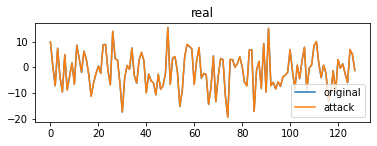

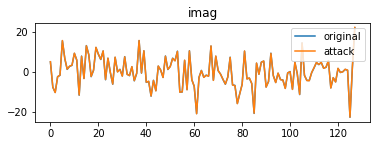

In [ ]:
epsilon = 0.1

adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)  # EagerTensor with shape (1, 2, 128)
example_untargeted_pred = model.predict(original_image) 
adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)  # ndarray with shape (1, 11) 给出了11个概率

# print(adv_example_untargeted_label.shape)
original = np.argmax(example_untargeted_pred)
attack = np.argmax(adv_example_untargeted_label_pred)
print(np.argmax(example_untargeted_pred),example_untargeted_pred)
print(np.argmax(adv_example_untargeted_label_pred),adv_example_untargeted_label_pred)

original_image_plt = np.reshape(original_image, (2,128))
real = original_image_plt[0]  #取（2，128）的行
imag = original_image_plt[1]

adv_example_untargeted_label_plt = np.reshape(adv_example_untargeted_label, (2,128))
real_adv = adv_example_untargeted_label_plt[0]  #取（2，128）的行
imag_adv = adv_example_untargeted_label_plt[1]

plt.figure()
# plt.suptitle('mods={},SNR={},attack={}'.format(np.argmax(example_untargeted_pred)),-10dB,np.argmax(adv_example_untargeted_label_pred)))
plt.subplot(2,1,1)
plt.plot(real,label='original')
plt.plot(real_adv,label='attack')
plt.title("real")
plt.legend()  #设置 legend 图例
plt.figure()
plt.subplot(2,1,2)
plt.plot(imag,label='original')
plt.plot(imag_adv,label='attack')
plt.title("imag")

plt.legend()  #设置 legend 图例

In [ ]:
x1 = original_image_plt
x2 = adv_example_untargeted_label_plt
# print(x1,x2)
x1_2 = x1 - x2
# print(x1_2)
x1_2_2 = np.multiply(x1_2,x1_2)  # 矩阵对应元素相乘就相当于各个元素平方
# print(x1_2_2.shape)
x1_2_2_sum = x1_2_2.sum(axis=1)  # axis=1求行和
x1_2_2_sum_chu = x1_2_2_sum / 128
# print(x1_2_2_sum,x1_2_2_sum_chu)
# print(x1_2_sum,abs(x1_2_sum))
x_sqrt = np.sqrt(x1_2_2_sum_chu)
print(x_sqrt) 

[0.1        0.10000002]
